In [1]:
%load_ext autoreload
%autoreload 2

### Import required libraries

In [2]:
import numpy as np
import pandas as pd

import csv as csv
import sklearn
import math
import matplotlib.pyplot as plt
from matplotlib import pyplot

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score,KFold,train_test_split,GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
import xgboost
import lightgbm as lgb

from utils import save_to_csv, reduce_memory_usage,custom_kfold_scorer 

### Open the CSV files containing train and test data

In [3]:
train_df = pd.read_csv("./train_2.csv")
test_df = pd.read_csv("./test_2.csv")

### Reduce the size of dataframe to save memory during training

In [4]:
train_df, _ = reduce_memory_usage(train_df)
test_df, _ = reduce_memory_usage(test_df)

Memory usage of properties dataframe is : 55.995635986328125  MB
__MEMORY USAGE AFTER COMPLETION:__
Memory usage is:  38.702903747558594  MB
This is  69.117714382257 % of the initial size
Memory usage of properties dataframe is : 13.1756591796875  MB
__MEMORY USAGE AFTER COMPLETION:__
Memory usage is:  9.264171600341797  MB
This is  70.31277504979849 % of the initial size


### Training data

In [5]:
train_df.head()

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,latitude,longitude,subzone,planning_area,region,resale_price,month_no,year,storey,lat_long
0,pasir ris,4-room,440,pasir ris drive 4,118.0,model a,1989,1.369008,103.958694,pasir ris drive,pasir ris,east region,209700.0,8,2001,2,"(1.3690080642700195, 103.95869445800781)"
1,punggol,5-room,196B,punggol field,110.0,improved,2003,1.399007,103.906990,punggol field,punggol,north-east region,402300.0,10,2014,11,"(1.3990070819854736, 103.90699005126953)"
2,sengkang,5-room,404A,fernvale lane,112.0,premium apartment,2004,1.388348,103.873817,fernvale,sengkang,north-east region,351000.0,9,2020,2,"(1.3883482217788696, 103.87381744384766)"
3,clementi,3-room,375,clementi avenue 4,67.0,new generation,1980,1.318493,103.766701,clementi north,clementi,west region,151200.0,10,2000,8,"(1.3184930086135864, 103.7667007446289)"
4,bukit batok,3-room,163,bukit batok street 11,73.0,model a,1985,1.348150,103.742661,bukit batok west,bukit batok,west region,318600.0,1,2013,8,"(1.3481495380401611, 103.74266052246094)"


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431732 entries, 0 to 431731
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   town                 431732 non-null  object 
 1   flat_type            431732 non-null  object 
 2   block                431732 non-null  object 
 3   street_name          431732 non-null  object 
 4   floor_area_sqm       431732 non-null  float32
 5   flat_model           431732 non-null  object 
 6   lease_commence_date  431732 non-null  uint16 
 7   latitude             431732 non-null  float32
 8   longitude            431732 non-null  float32
 9   subzone              431732 non-null  object 
 10  planning_area        431732 non-null  object 
 11  region               431732 non-null  object 
 12  resale_price         431732 non-null  float32
 13  month_no             431732 non-null  uint8  
 14  year                 431732 non-null  uint16 
 15  storey           

### Segregate the columns

In [7]:
integer_columns = [
    "lease_commence_date",
    "storey",
    "month_no",
    "year",
]

float_columns = [
    "floor_area_sqm",
]

target_column = [
    "resale_price"
]

## Categorical columns need to be encoded before training
categorical_columns = [
    "town",
    "flat_type",
    "flat_model",
    "subzone",
    "planning_area",
    "region"
]

## We will drop these columns before training
drop_columns = [
    "lat_long",
    "block",
    "street_name",
    #"latitude",
    #"longitude"
]

### Drop the selected columns

In [8]:
train_df = train_df.drop(columns=drop_columns)
test_df = test_df.drop(columns=drop_columns)

## Correlation between features

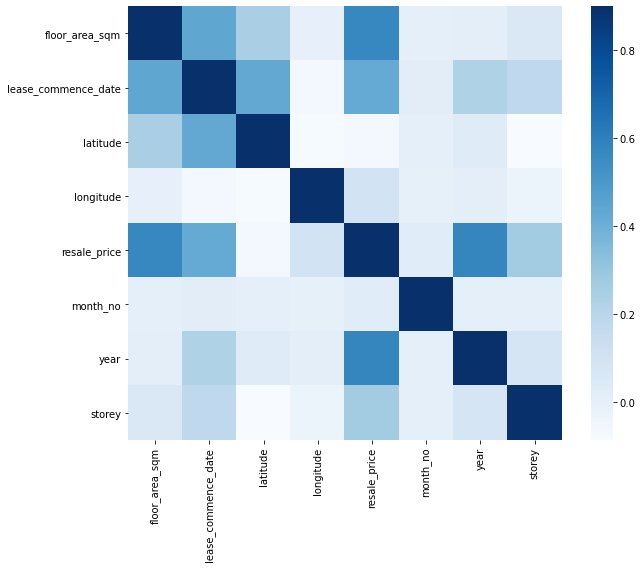

In [9]:
corr = train_df.corr()
plt.subplots(figsize=(10,8))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)
plt.tight_layout()
#plt.savefig("./correlation.tiff",dpi=300)

In [10]:
corr[['resale_price']].sort_values(by='resale_price',ascending=False).style.background_gradient(cmap='viridis', axis=None)

,resale_price
resale_price,1.000000
year,0.578717
floor_area_sqm,0.570385
lease_commence_date,0.423578
storey,0.269431
longitude,0.099786
month_no,0.025448
latitude,-0.065915


### One hot encode categorical columns

In [11]:
for col in categorical_columns:
    train_df = pd.concat([train_df, pd.get_dummies(train_df[col], prefix=col)],axis=1)
train_df = train_df.drop(columns=categorical_columns)

for col in categorical_columns:
    test_df = pd.concat([test_df, pd.get_dummies(test_df[col], prefix=col)],axis=1)
test_df = test_df.drop(columns=categorical_columns)

### Check if the columns in both test data and train data are same after one-hot encoding

In [12]:
columns_in_test_not_in_train = test_df.columns.difference(train_df.columns).tolist()
#print(columns_in_test_not_in_train)
columns_in_train_not_in_test = train_df.columns.difference((test_df.columns)).tolist()
columns_in_train_not_in_test.remove('resale_price')
#print(columns_in_train_not_in_test)
if not columns_in_test_not_in_train and not columns_in_train_not_in_test:
    print("Columns are same")

Columns are same


### Split training data into training and validation sets

In [13]:
train_data = train_df.sample(frac=1)
train_labels = train_data.pop('resale_price')
train_x, val_x, train_y, val_y = train_test_split(train_data,train_labels,train_size=0.8)

## Linear Regression

In [14]:
reg = LinearRegression(normalize=True,copy_X=True,n_jobs=-1)

In [15]:
%%time
reg.fit(train_x, train_y)

Wall time: 3.64 s


LinearRegression(n_jobs=-1, normalize=True)

In [16]:
train_prediction = reg.predict(train_x)
val_prediction = reg.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 53017.04
Validation error(RMSE) : 52967.934
R2 score for training data : 0.8335552698996025
R2 score for validation data : 0.832711960220969


-----------------------

## Decision Tree

#### Train using default hyperparameters

In [17]:
dt_1 = tree.DecisionTreeRegressor()

In [18]:
%%time
dt_1 = dt_1.fit(train_x, train_y)

Wall time: 10.1 s


In [19]:
train_prediction = dt_1.predict(train_x)
val_prediction = dt_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 1485.7150004070859
Validation error(RMSE) : 24809.947378602705
R2 score for training data : 0.9998692896218988
R2 score for validation data : 0.9632979306988151


#### Modify max_depth and min_samples_split and try next model

In [20]:
dt_3 = tree.DecisionTreeRegressor(max_depth=250,min_samples_split=15)
dt_3 = dt_3.fit(train_x, train_y)

In [21]:
train_prediction = dt_3.predict(train_x)
val_prediction = dt_3.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 13686.435335503309
Validation error(RMSE) : 22234.29588642651
R2 score for training data : 0.9889077473197283
R2 score for validation data : 0.9705228408494189


#### Modify max_depth and min_samples_split and max_features and try next model

In [22]:
%%time
dt_4 = tree.DecisionTreeRegressor(max_depth=250,min_samples_split=10,max_features=50)
dt_4 = dt_4.fit(train_x, train_y)

Wall time: 2.87 s


In [23]:
train_prediction = dt_4.predict(train_x)
val_prediction = dt_4.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 19369.002378885292
Validation error(RMSE) : 29645.856898098737
R2 score for training data : 0.9777846295577037
R2 score for validation data : 0.9475957052753393


#### Modify max_depth and min_samples_split and max_features and try next model

In [24]:
dt_2 = tree.DecisionTreeRegressor(max_depth=300,min_samples_split=30)

In [25]:
%%time
dt_2 = dt_2.fit(train_x, train_y)

Wall time: 8.49 s


In [26]:
train_prediction = dt_2.predict(train_x)
val_prediction = dt_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 16819.400615707233
Validation error(RMSE) : 22059.08045270159
R2 score for training data : 0.9832482537996327
R2 score for validation data : 0.9709855946657437


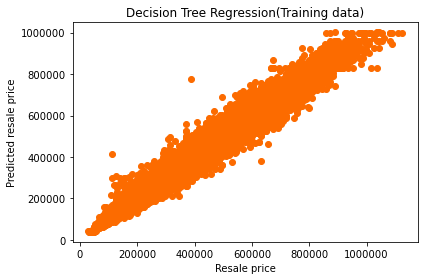

In [27]:
#plt.figure(figsize=(10,8))
plt.scatter(x=train_y,y=train_prediction, color = '#FC6B00')
#plt.scatter(val_prediction, val_y, color = 'green')
plt.title('Decision Tree Regression(Training data)')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.ticklabel_format(useOffset=False,style='plain')
plt.tight_layout()
plt.savefig("./dt_2_core_training_data.tiff",dpi=300)
plt.show()

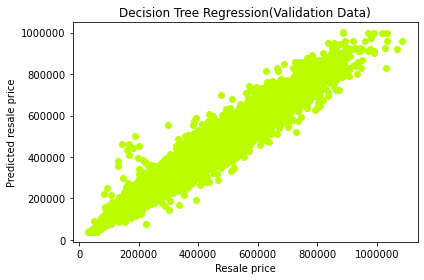

In [28]:
plt.scatter(x=val_y,y=val_prediction, color = '#BBFC00')
plt.title('Decision Tree Regression(Validation Data)')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.ticklabel_format(useOffset=False,style='plain')
plt.tight_layout()
plt.savefig("./dt_2_core_validation_data.tiff",dpi=300)
plt.show()

In [29]:
dt_2_feature_importance = pd.DataFrame({'Feature':train_x.columns,'Importance':dt_2.feature_importances_}).sort_values('Importance', ascending=False)

In [30]:
dt_2_feature_importance.head()

,Feature,Importance
5,year,0.422096
0,floor_area_sqm,0.293581
247,region_central region,0.085562
38,flat_type_executive,0.044211
1,lease_commence_date,0.038778


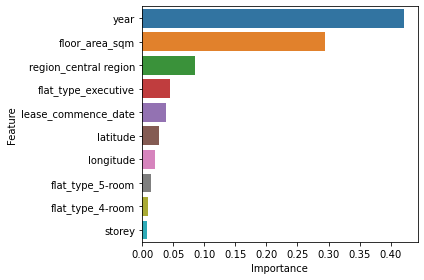

In [31]:
sns.barplot(y='Feature', x='Importance', data=dt_2_feature_importance.head(10))
plt.tight_layout()
plt.savefig("./dt_2_core_feature_importance.tiff",dpi=300)

In [122]:
scores = cross_val_score(dt_3, train_x, train_y, cv=5, scoring=custom_kfold_scorer)
print("5 fold Cross validation scores(RMSE)",scores)

5 fold Cross validation scores(RMSE) [23796.00631699 23362.31911505 23517.73451212 23610.09484359
 23380.13437972]


In [125]:
scores = cross_val_score(dt_3, train_x, train_y, cv=5, scoring='r2')
print("5 fold Cross validation scores(r2_score)",scores)

5 fold Cross validation scores(r2_score) [0.96634098 0.96781478 0.96699145 0.96705558 0.96743054]


----------------------------

## Random Forest

#### Run model using default parameters

In [57]:
rf_1 = RandomForestRegressor()

In [58]:
%%time
rf_1.fit(train_x,train_y)

Wall time: 11min 16s


RandomForestRegressor()

In [59]:
train_prediction = rf_1.predict(train_x)
val_prediction = rf_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 6888.594705567408
Validation error(RMSE) : 18118.982528806893
R2 score for training data : 0.997190038810327
R2 score for validation data : 0.9804247878688213


#### Modify max_depth and n_estimators and try next model

In [32]:
rf_2 = RandomForestRegressor(n_estimators=50,max_depth=10,n_jobs=-1,verbose=1)

In [33]:
%%time
rf_2.fit(train_x,train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min


Wall time: 1min 55s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.9min finished


RandomForestRegressor(max_depth=10, n_estimators=50, n_jobs=-1, verbose=1)

In [34]:
train_prediction = rf_2.predict(train_x)
val_prediction = rf_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Training error(RMSE) : 32074.397440503923
Validation error(RMSE) : 32487.463209015867
R2 score for training data : 0.9390805368900279
R2 score for validation data : 0.937068154757702


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


#### Modify max_depth and n_estimators and try next model

In [35]:
rf_3 = RandomForestRegressor(n_estimators=50,max_depth=50,n_jobs=-1,verbose=1)

In [36]:
%%time
rf_3.fit(train_x,train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min


Wall time: 2min 26s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.4min finished


RandomForestRegressor(max_depth=50, n_estimators=50, n_jobs=-1, verbose=1)

In [37]:
train_prediction = rf_3.predict(train_x)
val_prediction = rf_3.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.6s finished


Training error(RMSE) : 7022.347497577258
Validation error(RMSE) : 18210.837339568658
R2 score for training data : 0.9970798599039818
R2 score for validation data : 0.9802258103477632


#### Modify max_depth, n_estimators and max_features and try next model

In [38]:
rf_4 = RandomForestRegressor(n_estimators=50,max_depth=50,max_features=50,n_jobs=-1,verbose=1)

In [39]:
%%time
rf_4.fit(train_x,train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   38.2s


Wall time: 50.2 s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   49.9s finished


RandomForestRegressor(max_depth=50, max_features=50, n_estimators=50, n_jobs=-1,
                      verbose=1)

In [80]:
train_prediction = rf_4.predict(train_x)
val_prediction = rf_4.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    4.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.9s finished


Training error(RMSE) : 7339.414910580473
Validation error(RMSE) : 18750.477690061365
R2 score for training data : 0.9968102111601497
R2 score for validation data : 0.9790365123308903


In [81]:
feature_importance_rf_4 = pd.DataFrame({'Feature':train_x.columns,'Importance':rf_4.feature_importances_}).sort_values('Importance', ascending=False)

In [82]:
feature_importance_rf_4.head(10)

,Feature,Importance
5,year,0.369364
0,floor_area_sqm,0.151727
1,lease_commence_date,0.065242
35,flat_type_3-room,0.060440
2,latitude,0.048148
37,flat_type_5-room,0.039419
38,flat_type_executive,0.032901
247,region_central region,0.031217
36,flat_type_4-room,0.028993
6,storey,0.024273


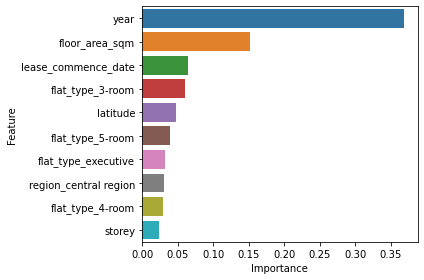

In [83]:
sns.barplot(y='Feature', x='Importance', data=feature_importance_rf_4.head(10))
plt.tight_layout()
plt.savefig("./rf_4_core_feature_importance.tiff",dpi=300)

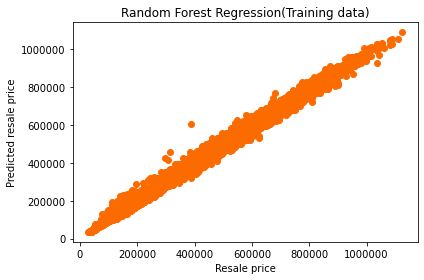

In [84]:
plt.scatter(x=train_y,y=train_prediction, color = '#FC6B00')
plt.title('Random Forest Regression(Training data)')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.ticklabel_format(useOffset=False,style='plain')
plt.tight_layout()
#plt.savefig("./rf_4_core_training_data.tiff",dpi=300)
plt.show()


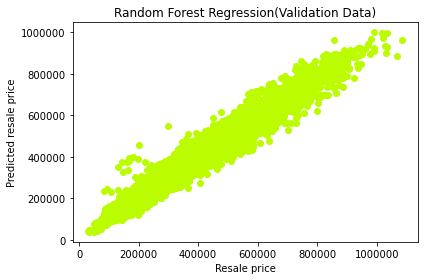

In [85]:
plt.scatter(x=val_y,y=val_prediction, color = '#BBFC00')
plt.title('Random Forest Regression(Validation Data)')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.ticklabel_format(useOffset=False,style='plain')
plt.tight_layout()
#plt.savefig("./rf_4_core_validation_data.tiff",dpi=300)
plt.show()

#### Uncomment next block to make prediction on test data and generate csv

In [46]:
#test_result = rf.predict(test_df)
#save_to_csv(test_result,"./random_forest_result.csv")

----------------------------

## XGBOOST

#### Run model using default parameters

In [83]:
xgb_model_1 = xgboost.XGBRegressor()

In [84]:
%%time
xgb_model_1.fit(train_x,train_y)

Wall time: 47.1 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [85]:
train_prediction = xgb_model_1.predict(train_x)
val_prediction = xgb_model_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 21459.51
Validation error(RMSE) : 21953.79
R2 score for training data : 0.9727214422770467
R2 score for validation data : 0.9713007033649169


#### Modify hyperparameters and try next model

In [47]:
xgb_model_2 = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=50,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

In [48]:
%%time
xgb_model_2.fit(train_x,train_y)

Wall time: 4min 9s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_delta_step=0, max_depth=50,
             min_child_weight=1.5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
             subsample=0.6, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [49]:
train_prediction = xgb_model_2.predict(train_x)
val_prediction = xgb_model_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 10451.854
Validation error(RMSE) : 21775.35
R2 score for training data : 0.9935311710298659
R2 score for validation data : 0.9717271775660316


In [50]:
feature_importance_xgb = pd.DataFrame({'Variable':train_x.columns,'Importance':xgb_model_2.feature_importances_}).sort_values('Importance', ascending=False)

In [51]:
feature_importance_xgb.head(10)

,Variable,Importance
38,flat_type_executive,0.173904
43,flat_model_dbss,0.083495
57,flat_model_terrace,0.050993
35,flat_type_3-room,0.048383
59,flat_model_type s2,0.047553
247,region_central region,0.039145
34,flat_type_2-room,0.034846
33,flat_type_1-room,0.027010
36,flat_type_4-room,0.024888
37,flat_type_5-room,0.023735


In [52]:
train_prediction = xgb_model_2.predict(train_x)
val_prediction = xgb_model_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 10451.854
Validation error(RMSE) : 21775.35
R2 score for training data : 0.9935311710298659
R2 score for validation data : 0.9717271775660316


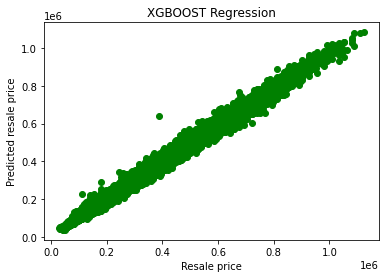

In [53]:
plt.scatter(train_y,train_prediction, color = 'green')
plt.title('XGBOOST Regression')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.show()

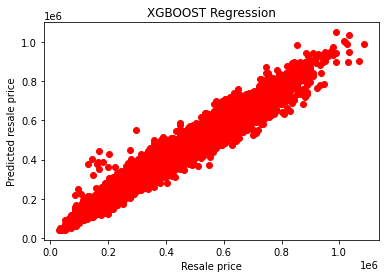

In [54]:
plt.scatter(val_y,val_prediction, color = 'red')
plt.title('XGBOOST Regression')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.show()

#### Uncomment next block to make prediction on test data and generate csv

In [55]:
#test_result = best_xgb_model.predict(test_df)
#save_to_csv(test_result,"./xgboost_result.csv")

-------------------------------------

## Prediction using Random Forest and XGBOOST together

In [60]:
xgb_model_2_prediction = xgb_model_2.predict(train_x)
rf_1_prediction = rf_1.predict(train_x)
final_pred = 0.7*rf_1_prediction + 0.3*xgb_model_2_prediction
print("Training error :",mean_squared_error(train_y, final_pred, squared=False))
print("R2 score for training data :",r2_score(train_y,final_pred))

Training error : 7291.639152759956
R2 score for training data : 0.9968516037170233


In [61]:
xgb_model_2_prediction = xgb_model_2.predict(val_x)
rf_1_prediction = rf_1.predict(val_x)
final_pred = 0.7*rf_1_prediction + 0.3*xgb_model_2_prediction
print("Validation error :",mean_squared_error(val_y, final_pred, squared=False))
print("R2 score for validation data :",r2_score(val_y,final_pred))

Validation error : 17794.286568647614
R2 score for validation data : 0.9811200854035397


In [63]:
xgb_model_2_test_prediction = xgb_model_2.predict(test_df)
rf_1_test_prediction = rf_1.predict(test_df)
final_pred_t = 0.7*rf_1_test_prediction + 0.3*xgb_model_2_test_prediction
#save_to_csv(final_pred_t, "./xgb_rf_result.csv")

----------------------

## LightGBM

#### Run model using default hyperparameters

In [64]:
gbm_1 = lgb.LGBMRegressor()

In [65]:
gbm_1 = gbm_1.fit(train_x,train_y)

In [66]:
train_prediction = gbm_1.predict(train_x)
val_prediction = gbm_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 23534.071099928722
Validation error(RMSE) : 23854.57385624206
R2 score for training data : 0.96720307120842
R2 score for validation data : 0.9660701304527094


#### Modify learning_rate, max_depth and n_estimators and try next model

In [67]:
gbm_2 = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.1,
                        max_depth=10000,n_estimators=10000)

In [68]:
gbm_2 = gbm_2.fit(train_x,train_y)

In [69]:
train_prediction = gbm_2.predict(train_x)
val_prediction = gbm_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 11854.9141721129
Validation error(RMSE) : 16080.53780129067
R2 score for training data : 0.9916778434198905
R2 score for validation data : 0.9845815753315376


In [70]:
feature_importance_gbm_2 = pd.DataFrame({'Feature':train_x.columns,'Importance':gbm_2.feature_importances_}).sort_values('Importance', ascending=False)

In [71]:
feature_importance_gbm_2.head(10)

,Feature,Importance
5,year,66584
0,floor_area_sqm,43781
4,month_no,38483
2,latitude,37175
3,longitude,30796
6,storey,27118
1,lease_commence_date,17752
36,flat_type_4-room,2276
47,flat_model_model a,1946
44,flat_model_improved,1911


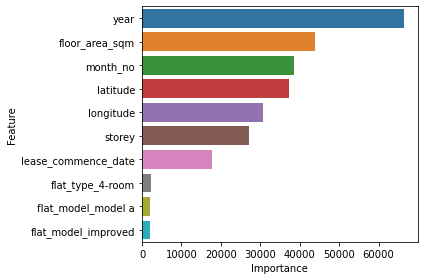

In [72]:
sns.barplot(y='Feature', x='Importance', data=feature_importance_gbm_2.head(10))
plt.tight_layout()
#plt.savefig("./gbm_2_core_feature_importance.tiff",dpi=300)

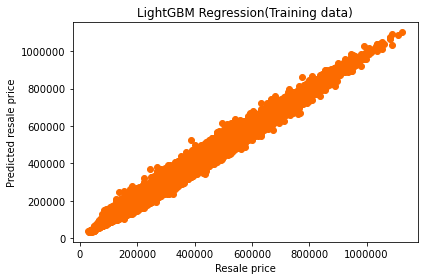

In [73]:
#plt.figure(figsize=(10,8))
plt.scatter(x=train_y,y=train_prediction, color = '#FC6B00')
#plt.scatter(val_prediction, val_y, color = 'green')
plt.title('LightGBM Regression(Training data)')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.ticklabel_format(useOffset=False,style='plain')
plt.tight_layout()
#plt.savefig("./gbm_2_core_training_data.tiff",dpi=300)
plt.show()

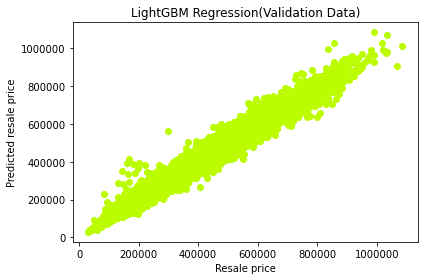

In [74]:
plt.scatter(x=val_y,y=val_prediction, color = '#BBFC00')
plt.title('LightGBM Regression(Validation Data)')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.ticklabel_format(useOffset=False,style='plain')
plt.tight_layout()
#plt.savefig("./gbm_2_core_validation_data.tiff",dpi=300)
plt.show()

#### Change max_depth and n_estimators and try next model

In [75]:
%%time
gbm_3 = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.1,
                        max_depth=5000,n_estimators=5000)

Wall time: 0 ns


In [76]:
gbm_3.fit(
    train_x, train_y, 
    eval_set= [(train_x, train_y), (val_x, val_y)], 
    eval_metric='rmse', verbose=1000)

[1000]	training's rmse: 16552.1	training's l2: 2.73973e+08	valid_1's rmse: 17431.8	valid_1's l2: 3.03869e+08
[2000]	training's rmse: 15214.4	training's l2: 2.31478e+08	valid_1's rmse: 16636.2	valid_1's l2: 2.76763e+08
[3000]	training's rmse: 14412	training's l2: 2.07707e+08	valid_1's rmse: 16311.4	valid_1's l2: 2.66061e+08
[4000]	training's rmse: 13845	training's l2: 1.91683e+08	valid_1's rmse: 16180.4	valid_1's l2: 2.61807e+08
[5000]	training's rmse: 13383.7	training's l2: 1.79123e+08	valid_1's rmse: 16106.9	valid_1's l2: 2.59433e+08


LGBMRegressor(max_depth=5000, n_estimators=5000)

In [77]:
train_prediction = gbm_3.predict(train_x)
val_prediction = gbm_3.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 13383.70122192974
Validation error(RMSE) : 16106.91430564865
R2 score for training data : 0.9893930256104787
R2 score for validation data : 0.984530952934773


#### Uncomment next block to make prediction on test data and generate csv

In [78]:
#gbm_test_result = gbm.predict(test_df)
#save_to_csv(gbm_test_result,"./lgbm_result.csv")

## Prediction using Random Forest, XGBOOST and LightGBM together

In [79]:
print("Training error :",mean_squared_error(train_y, , squared=False))
print("Validation error :",mean_squared_error(val_y, 0.4*gbm_2.predict(val_x)+ 0.4*rf_1.predict(val_x) +0.2*xgb_model_2.predict(val_x), squared=False))

SyntaxError: invalid syntax (<ipython-input-79-f34b685ccabd>, line 1)

In [ ]:
train_prediction = 0.4*gbm_2.predict(train_x) + 0.4*rf_1.predict(train_x) +0.2*xgb_model_2.predict(train_x)
val_prediction = 0.4*gbm_2.predict(val_x)+ 0.4*rf_1.predict(val_x) +0.2*xgb_model_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

#### Uncomment next block to make prediction on test data and generate csv

In [117]:
#test_result = 0.4*gbm_2.predict(test_df) + 0.4*rf_1.predict(test_df) +0.2*xgb_model_2.predict(test_df)
#save_to_csv(test_result,"./lgbm_xgboost_rf_result.csv")